<a href="https://colab.research.google.com/github/mrudulagavas/All-About-AI-ML/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


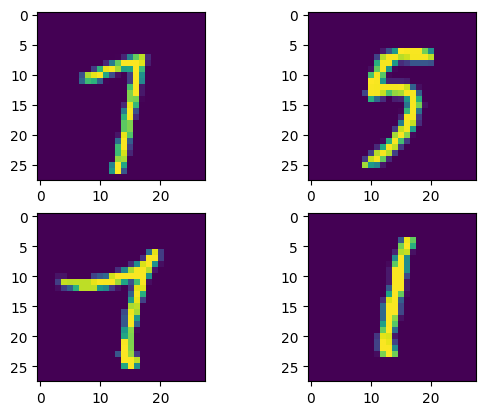

In [ ]:
#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel

x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])
plt.subplot(222)
plt.imshow(x_train[420][:,:,0])
plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])
plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()

In [ ]:

latent_dim = 2 # Number of latent dim parameters
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = x.shape #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x) #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x) #Std dev. (variance) of encoded input

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

# reshape to the shape of last c22.19seconv. layer in the encoder, so we can
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)

#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12544)               │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# apply the decoder to the latent sample
z_decoded = decoder(z)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

class CustomLayer(keras.layers.Layer):

  def vae_loss(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    z_mu = inputs[2]
    z_sigma = inputs[3]
    x = tf.keras.backend.flatten(x)
    z_decoded = tf.keras.backend.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    loss = self.vae_loss(inputs)
    self.add_loss(loss)
    return inputs[0]

y = CustomLayer() ([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │        401,440 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 2)              │             66 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 1)      │         56,385 │ z[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer              │ (None, 28, 28, 1)      │              0 │ encoder_input[0][0],   │
│ (CustomLayer)             │                        │                │ decoder[0][0],         │
│                           │                        │                │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 550,629 (2.10 MB)

 Trainable params: 550,629 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train autoencoder
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.2683 - val_loss: 0.2076
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2054 - val_loss: 0.1977
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1966 - val_loss: 0.1939
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1931 - val_loss: 0.1908
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1906 - val_loss: 0.1887
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1891 - val_loss: 0.1888
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1871 - val_loss: 0.1864
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1856 - val_loss: 0.1874
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1853 - val_loss: 0.1850
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1837 - val_loss: 0.1842


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


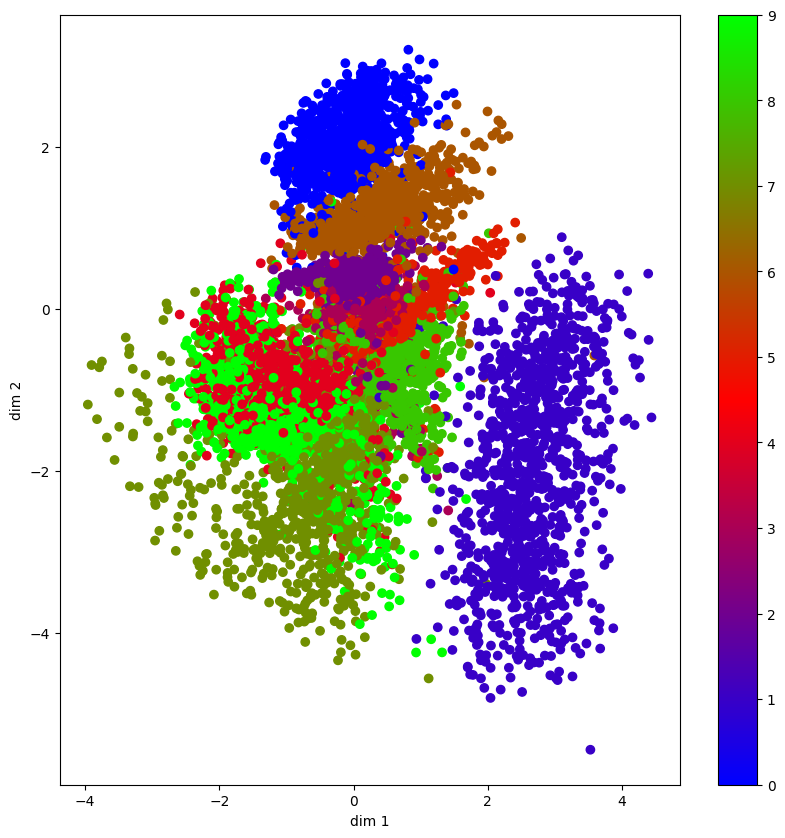

In [ ]:

#Extract z_mu --> first parameter in the result of encoder prediction representing mean
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


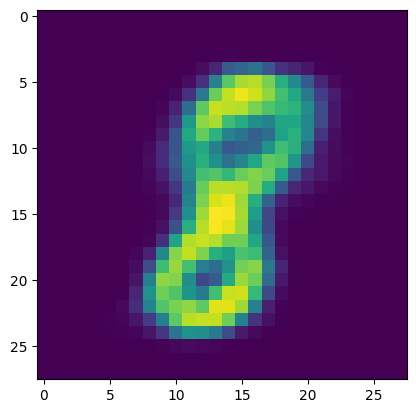

In [ ]:
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

In [ ]:
n = 20 # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(img_width, img_height, num_channels)
    figure[i * img_width: (i + 1) * img_width,j * img_height: (j + 1) * img_height] = digit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

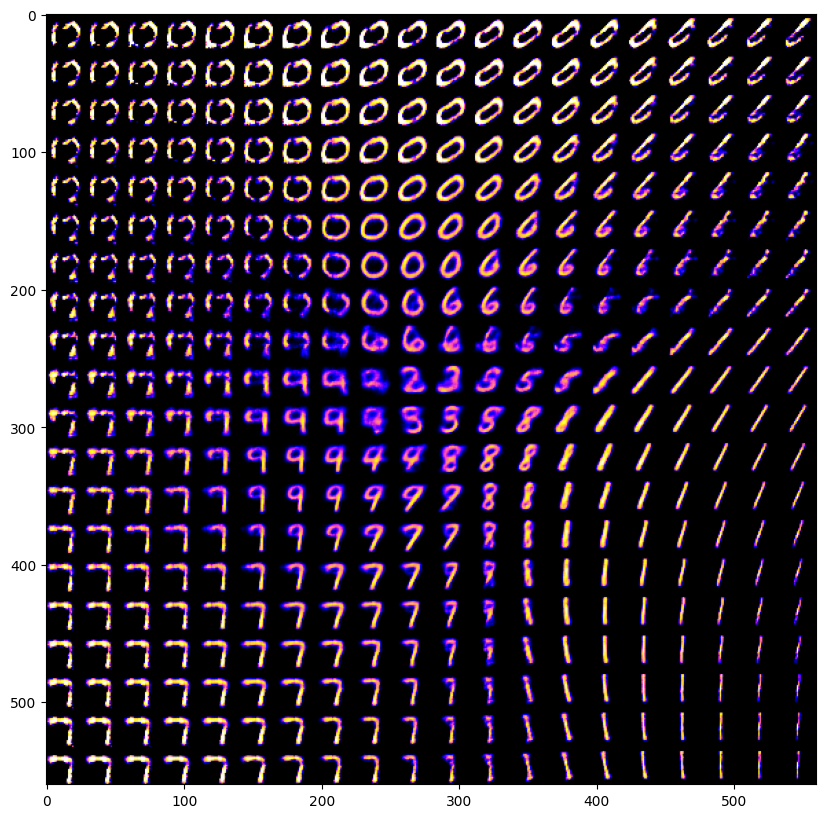

In [ ]:
plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.show()